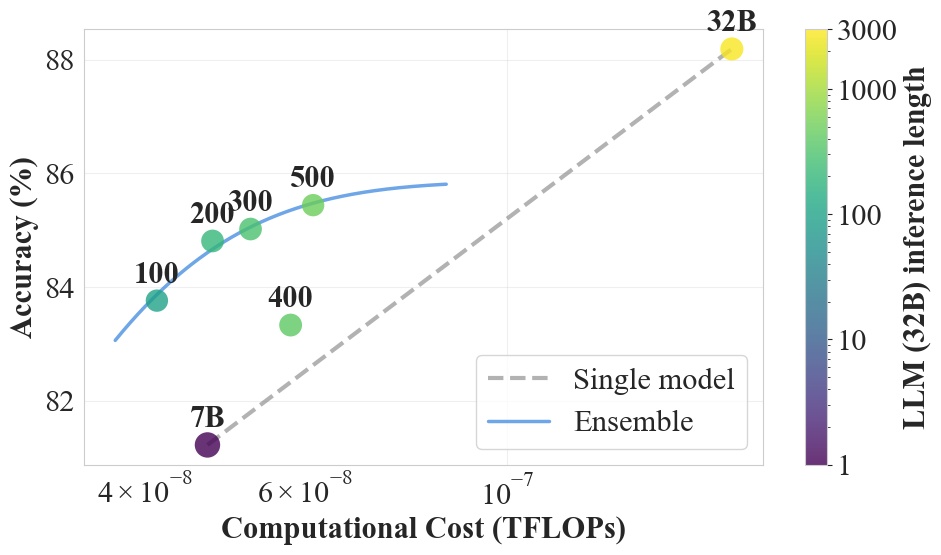

In [12]:
"""
Model Switching Performance Analysis

This script visualizes the performance of different model switching strategies:
- 7B: Single 7B model
- 100-500: 32B model generates first N tokens, then switches to 7B
- 32B: Single 32B model
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Rectangle
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import matplotlib as mpl       # 新增：直接操作 mpl.rcParams

# —— 全局字体设置 ——
mpl.rcParams.update({
    "font.family": "Times New Roman",  # 全局字体
    "font.size": 22,                   # 全局字号
    "mathtext.fontset": "stix",        # 数学公式匹配 Times 系列
    "axes.unicode_minus": False,       # 解决负号显示问题
    # 可选：使 PDF/PS 文件嵌入 TrueType 字体，排版更稳定
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# 也可继续使用 seaborn 的配色 / 网格
sns.set_style("whitegrid")

# Set style
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22

# Data from the table
data = {
    'strategy': ['7B', '100', '200', '300', '400', '500', '32B'],
    'accuracy': [81.22, 83.76, 84.81, 85.02, 83.33, 85.44, 88.19],
    'avg_length': [3348, 2589, 2677, 2662, 2703, 2588, 2758],
    'switch_tokens': [0, 100, 200, 300, 400, 500, 2758]  # 0 means no switch
}

df = pd.DataFrame(data)

# Model parameters
MODEL_SIZE_7B = 7  # billion parameters
MODEL_SIZE_32B = 32  # billion parameters

# Calculate approximate FLOPs for each strategy
# Formula: FLOPs ≈ 2 * num_params * num_tokens (for inference)
# This is a simplified estimation

def calculate_flops(strategy_row):
    strategy = strategy_row['strategy']
    avg_length = strategy_row['avg_length']
    switch_tokens = strategy_row['switch_tokens']

    if strategy == '7B':
        # Pure 7B model
        flops = 2 * MODEL_SIZE_7B * avg_length
    elif strategy == '32B':
        # Pure 32B model
        flops = 2 * MODEL_SIZE_32B * avg_length
    else:
        # Switching strategy: 32B for first N tokens, then 7B for the rest
        flops_32b = 2 * MODEL_SIZE_32B * switch_tokens
        flops_7b = 2 * MODEL_SIZE_7B * (avg_length - switch_tokens)
        flops = flops_32b + flops_7b

    return flops / 1e12  # Convert to TFLOPs

df['tflops'] = df.apply(calculate_flops, axis=1)

# Calculate relative metrics
df['relative_accuracy'] = df['accuracy'] / df['accuracy'].max() * 100
df['relative_flops'] = df['tflops'] / df['tflops'].max() * 100

# Identify optimal strategies
efficiency_score = df['accuracy'] / df['tflops']  # Accuracy per TFLOP
df['efficiency_score'] = efficiency_score
best_efficiency_idx = efficiency_score.idxmax()


# Create a combined efficiency plot with log scale colorbar
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare switch tokens for log scale (replace 0 with 1 for log scale)
switch_tokens_log = df['switch_tokens'].copy()
switch_tokens_log[switch_tokens_log == 0] = 1

# Connect 7B and 32B with a gray dashed line (draw first so it's behind)
idx_7b = df[df['strategy'] == '7B'].index[0]
idx_32b = df[df['strategy'] == '32B'].index[0]
ax.plot([df.loc[idx_7b, 'tflops'], df.loc[idx_32b, 'tflops']],
        [df.loc[idx_7b, 'accuracy'], df.loc[idx_32b, 'accuracy']],
        '--', color='gray', linewidth=3, alpha=0.6, label='Single model', zorder=1)

# Create scatter plot with size based on response length
scatter = ax.scatter(df['tflops'], df['accuracy'],
                    s=df['avg_length']/10,  # Scale down for visualization
                    c=switch_tokens_log,
                    cmap='viridis',
                    alpha=0.8,
                    edgecolors='none',  # Remove black borders
                    linewidth=0,
                    norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=3000),
                    zorder=3)

# Fit a logarithmic curve through switching strategies (excluding 400)
switching_strategies = df[(df['strategy'] != '7B') & (df['strategy'] != '32B') & (df['strategy'] != '400')]
if len(switching_strategies) > 1:
    # Use logarithmic fitting

    # Define asymptotic functions that approach a maximum value

    # Method 1: Negative exponential (1 - exp(-x)) type
    def neg_exp_func(x, a, b, c):
        """a: asymptote, b: rate, c: x-offset"""
        return a * (1 - np.exp(-b * (x - c)))

    # Method 2: Michaelis-Menten type (hyperbolic)
    def mm_func(x, a, b):
        """a: maximum value, b: half-saturation constant"""
        return a * x / (b + x)

    # Method 3: Logistic/Sigmoid function
    def sigmoid_func(x, a, b, c, d):
        """a: asymptote, b: growth rate, c: x-midpoint, d: y-offset"""
        return a / (1 + np.exp(-b * (x - c))) + d

    X = switching_strategies['tflops'].values
    y = switching_strategies['accuracy'].values

    best_r_squared = 0
    best_fit = None
    best_label = ""

    # Method 4: Power function with asymptote (more curved)
    def power_asymptote_func(x, a, b, c, d):
        """a: asymptote, b: coefficient, c: power, d: offset"""
        return a - b * np.power(x + d, -c)

    # Method 5: Square root function (more curved)
    def sqrt_asymptote_func(x, a, b, c):
        """a: asymptote, b: rate, c: offset"""
        return a - b / np.sqrt(x + c)


    # Manual curved line - no fitting, just fixed curved shape
    x_fit = np.linspace(X.min() * 0.9, X.max() * 1.4, 200)

    # Create a very curved shape: fast rise then level off at ~87%
    def manual_curve(x):
        # Normalize x to 0-1 range
        x_norm = (x - x_fit.min()) / (x_fit.max() - x_fit.min())
        # Strong curvature: 82 + 5 * (1 - exp(-8*x))
        return 82.5 + 2.8 * (1.2 - np.exp(-4 * x_norm))

    y_fit = manual_curve(x_fit)
    best_fit = (x_fit, y_fit)
    best_label = 'Ensemble'
    best_r_squared = 1.0  # Not meaningful anymore


    # Plot the best fit
    if best_fit is not None:
        ax.plot(best_fit[0], best_fit[1], '-', color='#4A90E2', linewidth=2.5, alpha=0.8,
                label=best_label, zorder=2)
    else:
        # Fallback to simple logarithmic if all else fails
        def log_func(x, a, b, c):
            return a * np.log(b * x) + c
        try:
            popt, _ = curve_fit(log_func, X, y, p0=[2, 1, 80])
            x_fit = np.linspace(X.min() * 0.9, X.max() * 1.1, 200)
            y_fit = log_func(x_fit, *popt)

            residuals = y - log_func(X, *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((y - np.mean(y))**2)
            r_squared = 1 - (ss_res / ss_tot)

            ax.plot(x_fit, y_fit, '-', color='#4A90E2', linewidth=2.5, alpha=0.8,
                    label=f'Ensemble (R²={r_squared:.3f})', zorder=2)
        except:
            pass

# Add labels for each point (above the points)
for idx, row in df.iterrows():
    ax.annotate(row['strategy'],
                (row['tflops'], row['accuracy']),
                xytext=(0, 8),  # Directly above the point
                textcoords='offset points',
                fontweight='bold',
                ha='center',  # Center horizontally
                va='bottom',  # Bottom align to point upward
                zorder=4)

# Add colorbar with log scale
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('LLM (32B) inference length', fontweight='bold')
cbar.ax.set_yticks([1, 10, 100, 1000, 3000])
cbar.ax.set_yticklabels(['1', '10', '100', '1000', '3000'])

# Set x-axis to log scale
ax.set_xscale('log')

# Labels and title
ax.set_xlabel('Computational Cost (TFLOPs)', fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontweight='bold')

# Set tick label size
ax.tick_params(axis='both')

# Add grid
ax.grid(True, alpha=0.3)

# Add legend
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('model_switching_efficiency.pdf', dpi=300, bbox_inches='tight')
plt.show()


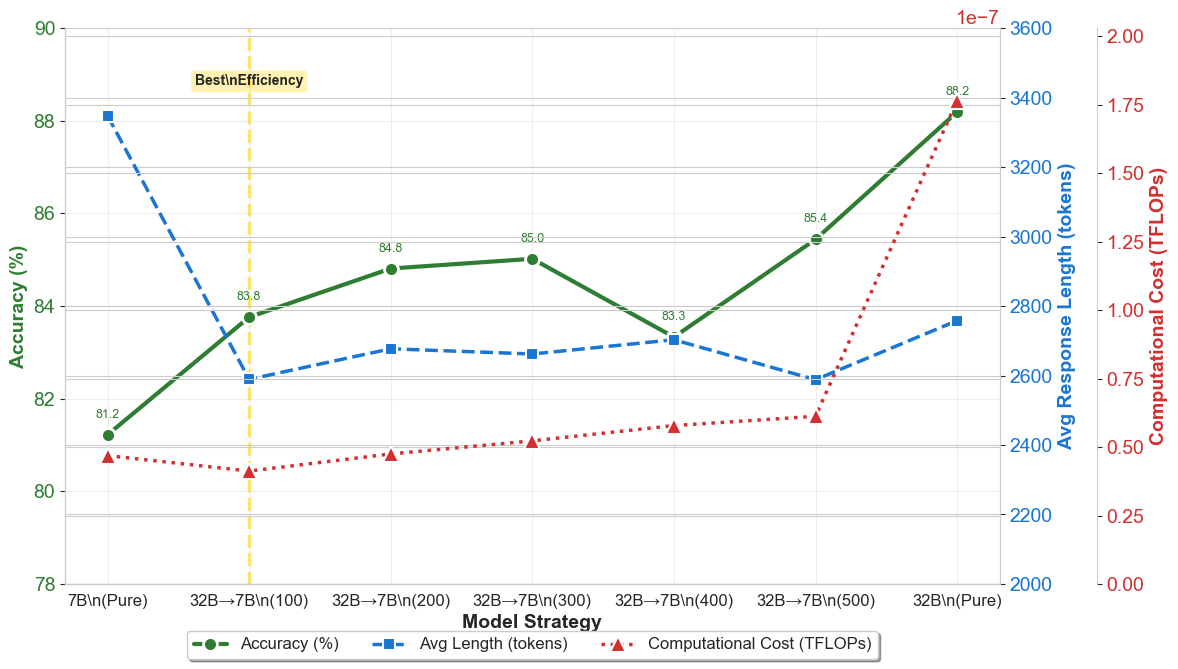

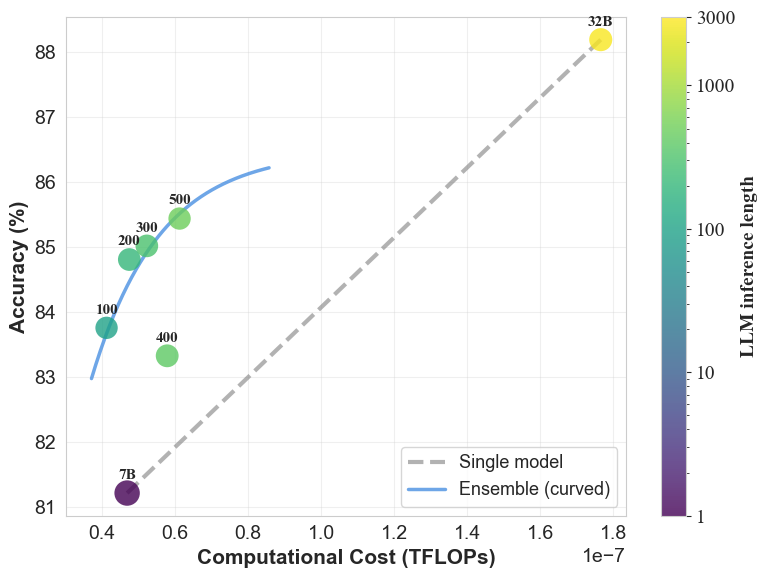